In [4]:
import datetime
import geopandas
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2023-05-05 14:47:42.389825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# TODO try only with best performing numeric columns for input into model first
# TODO select features for deep learning model after ranking features with random forest (feature importance)
# TODO lstm network
# TODO SMOTE algorithm, for upsampling havested fields; we only have ~300 :(

In [6]:
#local scripts
from scripts import veg_indices, utilities, plots
#from scripts.utilities import *

In [7]:
# cpied from learning_about-data.ipynb
BANDS_DICT = {   'B2': 'Blue',
            'B3': 'Green',
            'B4': 'Red',
            'B5': 'Red_Edge_1',
            'B6': 'Red_Edge_2',
            'B7': 'Red_Edge_3',
            'B8': 'NIR',
            'B8A': 'Red_Edge_4',
            'B11': 'SWIR_1',
            'B12': 'SWIR_2'}

BANDS = list(BANDS_DICT.keys())

In [8]:
# cpied from learning_about-data.ipynb
DF = geopandas.read_file('../data/merged_images.geojson')
DF.rename(columns = {'is_within_period':'har_evnt'}, inplace = True)
NUM_SAMPLES = len(np.unique(DF.image_idx)) - 1

In [9]:
DF

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,NDVI,finHarvDat,lat,lon,point_idx,start_date,end_date,har_evnt,image_idx,geometry
0,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,2022-08-11,50.655048,25.458684,p0,2022-01-08,2022-01-28,False,i0,POINT (25.45868 50.65505)
1,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,NaT,50.294633,36.289471,p1,2022-01-08,2022-01-28,False,i0,POINT (36.28947 50.29463)
2,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,NaT,50.860849,32.548484,p2,2022-01-08,2022-01-28,False,i0,POINT (32.54848 50.86085)
3,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,NaT,50.928689,31.637558,p3,2022-01-08,2022-01-28,False,i0,POINT (31.63756 50.92869)
4,0.1424,0.1083,0.030,0.0432,0.0631,0.07150,0.07760,0.08510,0.1066,0.1043,0.256335,2022-07-23,48.307964,37.348245,p4,2022-01-08,2022-01-28,False,i0,POINT (37.34824 48.30796)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9481,0.2557,0.1875,0.065,0.0740,0.0973,0.11695,0.14255,0.15525,0.1920,0.1847,0.327342,NaT,49.723156,36.817274,p553,2022-12-10,2022-12-30,False,i16,POINT (36.81727 49.72316)
9482,0.1616,0.1235,0.028,0.0442,0.0525,0.06390,0.08950,0.09310,0.1152,0.1073,0.373882,NaT,45.578351,28.700480,p554,2022-12-10,2022-12-30,False,i16,POINT (28.70048 45.57835)
9483,0.1675,0.1030,0.043,0.0678,0.0460,0.10960,0.23980,0.26430,0.2832,0.2783,0.720535,NaT,46.693510,35.051003,p555,2022-12-10,2022-12-30,False,i16,POINT (35.05100 46.69351)
9484,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,2022-07-30,50.451929,33.668204,p556,2022-12-10,2022-12-30,False,i16,POINT (33.66820 50.45193)


In [10]:
# cpied from learning_about-data.ipynb
df = DF.copy()
df = df[(df.NDVI) != 0] # drop invalid points
VEG_INDICES_NAMES = veg_indices.add_veg_indices(df) + ['NDVI'] 
VEG_DIFF_NAMES = veg_indices.add_veg_diff(df, VEG_INDICES_NAMES)
NUMERIC_COLS = BANDS + VEG_INDICES_NAMES + VEG_DIFF_NAMES
df = df.dropna(subset=['sample_idx']) # removes the first image, because sample_idx is NaN there


""" 
# only look at samples 6, 7, 8, 9
new_df = None
for i in range(6, 9 + 1):

    curr_df = df[df["sample_idx"] == f"s{i}"]
    if(type(new_df) == type(None)):
        new_df = curr_df
    else:
        new_df = pd.concat([new_df, curr_df])
df = new_df
"""

print(df.columns, df.shape)


# For each 3-week image, standarize each column
df = utilities.get_rm_outlier_standarize(df, NUMERIC_COLS, rm_outliers=False)




Added:  ['DVI', 'RVI', 'ARVI', 'PSSRa', 'NDI45', 'GNDVI', 'MCARI', 'IRECI', 'CIr', 'MTCI', 'NDVIre', 'NIRv', 'EVI', 'NDTI', 'NDMI', 'MSI', 'GCI', 'NBRI', 'BSI', 'NDWI', 'NDSI']
Added:  ['sample_idx', 'DVI_diff', 'RVI_diff', 'ARVI_diff', 'PSSRa_diff', 'NDI45_diff', 'GNDVI_diff', 'MCARI_diff', 'IRECI_diff', 'CIr_diff', 'MTCI_diff', 'NDVIre_diff', 'NIRv_diff', 'EVI_diff', 'NDTI_diff', 'NDMI_diff', 'MSI_diff', 'GCI_diff', 'NBRI_diff', 'BSI_diff', 'NDWI_diff', 'NDSI_diff', 'NDVI_diff']
Index(['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'NDVI',
       'finHarvDat', 'lat', 'lon', 'point_idx', 'start_date', 'end_date',
       'har_evnt', 'image_idx', 'geometry', 'DVI', 'RVI', 'ARVI', 'PSSRa',
       'NDI45', 'GNDVI', 'MCARI', 'IRECI', 'CIr', 'MTCI', 'NDVIre', 'NIRv',
       'EVI', 'NDTI', 'NDMI', 'MSI', 'GCI', 'NBRI', 'BSI', 'NDWI', 'NDSI',
       'pt_idx', 'img_idx', 'DVI_diff', 'RVI_diff', 'ARVI_diff', 'PSSRa_diff',
       'NDI45_diff', 'GNDVI_diff', 'MCARI_diff', 'IRECI_d

### Upsample harvevnt == true

In [13]:
har_evnt_true_df = df[df["har_evnt"]]
har_evnt_false_df = df[df["har_evnt"] == False]
print(har_evnt_true_df.shape)
print(har_evnt_false_df.shape)

(328, 66)
(6350, 66)


In [17]:
from sklearn.utils import resample

upsampled_har_evnt_true_df = resample(har_evnt_true_df, n_samples=har_evnt_false_df.shape[0],
                                                 replace=True, random_state=42)
upsampled_har_evnt_true_df.shape

(6350, 66)

In [ ]:
df = pd.concat([upsampled_har_evnt_true_df, har_evnt_false_df])
df.shape

In [47]:
            
points_df_list = []
for p in  df['point_idx'].unique(): # ['p0','p1','p2','p3','p4', ...]
    curr_df = df[df["point_idx"] == p]
    points_df_list.append(curr_df)
len(points_df_list)

556

# Separate Train, Val datasets

In [57]:
from sklearn.model_selection import train_test_split

training_df_list, validation_df_list = train_test_split(points_df_list, train_size=0.8, random_state=42)


In [58]:
print(len(training_df_list))
print(len(validation_df_list))



444
112


# combine into two dataframes


In [59]:
train_df = pd.concat(training_df_list)
validate_df = pd.concat(validation_df_list)
train_df.shape, validate_df.shape

((9971, 66), (2729, 66))

# Convert to Numpy

In [62]:

def get_X_y(dataframe: pd.DataFrame):
    df_X = dataframe[VEG_DIFF_NAMES]
    df_X = df_X.drop(['DVI_diff'], axis=1) # drop nan col
    X = df_X.to_numpy().reshape((df_X.shape[0], df_X.shape[1], 1))
    y = dataframe["har_evnt"].to_numpy().astype(np.float32)
    return X, y

In [64]:
X_train, y_train = get_X_y(train_df)
print(X_train.shape, y_train.shape)
X_validate, y_validate = get_X_y(validate_df)
print(X_validate.shape, y_validate.shape)


(9971, 21, 1) (9971,)
(2729, 21, 1) (2729,)


In [69]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

model = tf.keras.Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    BatchNormalization(),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

#model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 19, 32)            128       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 9, 32)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 288)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 288)              1152      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 64)                18496     
                                                                 
 dense_9 (Dense)             (None, 32)               

In [71]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])


In [72]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_validate, y_validate))


Epoch 1/50
312/312 [==============================] - 4s 6ms/step - loss: 0.4760 - binary_accuracy: 0.7738 - val_loss: 0.6134 - val_binary_accuracy: 0.7402
Epoch 2/50
312/312 [==============================] - 1s 4ms/step - loss: 0.3600 - binary_accuracy: 0.8458 - val_loss: 0.6562 - val_binary_accuracy: 0.7658
Epoch 3/50
312/312 [==============================] - 1s 4ms/step - loss: 0.3051 - binary_accuracy: 0.8766 - val_loss: 0.6273 - val_binary_accuracy: 0.7790
Epoch 4/50
312/312 [==============================] - 1s 4ms/step - loss: 0.2815 - binary_accuracy: 0.8892 - val_loss: 0.7664 - val_binary_accuracy: 0.7787
Epoch 5/50
312/312 [==============================] - 1s 4ms/step - loss: 0.2576 - binary_accuracy: 0.8997 - val_loss: 0.7314 - val_binary_accuracy: 0.7889
Epoch 6/50
312/312 [==============================] - 1s 4ms/step - loss: 0.2391 - binary_accuracy: 0.9083 - val_loss: 0.8024 - val_binary_accuracy: 0.7453
Epoch 7/50
312/312 [==============================] - 1s 4ms/ste

In [73]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

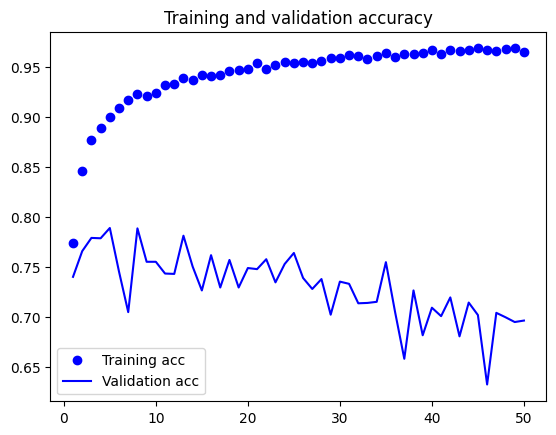

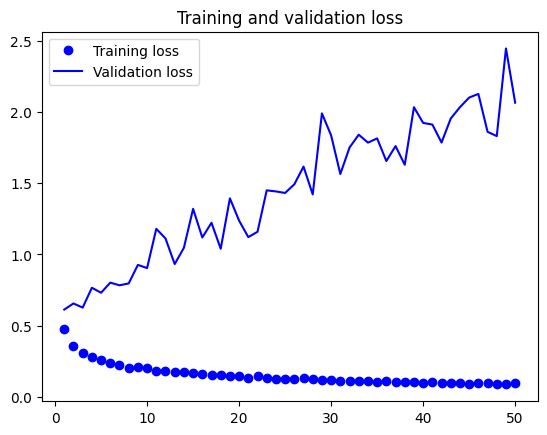

In [74]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [75]:
from sklearn.model_selection import train_test_split

trainX, testX, trainy, testy =  train_test_split(X, Y, test_size = 0.4,random_state=42) 

evaluate_model(trainX, trainy, testX, testy)

ValueError: in user code:

    File "/Users/tahaalnufaili/Library/Caches/pypoetry/virtualenvs/harvest-event-detec-Fyp2lGEN-py3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/tahaalnufaili/Library/Caches/pypoetry/virtualenvs/harvest-event-detec-Fyp2lGEN-py3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/tahaalnufaili/Library/Caches/pypoetry/virtualenvs/harvest-event-detec-Fyp2lGEN-py3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/tahaalnufaili/Library/Caches/pypoetry/virtualenvs/harvest-event-detec-Fyp2lGEN-py3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/Users/tahaalnufaili/Library/Caches/pypoetry/virtualenvs/harvest-event-detec-Fyp2lGEN-py3.9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/tahaalnufaili/Library/Caches/pypoetry/virtualenvs/harvest-event-detec-Fyp2lGEN-py3.9/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 1249, 57), found shape=(None, 57)


In [ ]:
testX.shape, trainy.shape

((1249, 1), (834, 57))